In [18]:
from sqlalchemy import create_engine, Table, Column, Integer, String, Float, MetaData,text
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
host = 'localhost'
port = '3306'
database = 'company'
username = 'root'
password = 'GYHxiao0606!'

engine = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}')
metadata = MetaData()

In [4]:
employee_data = Table('employee_data', metadata,
    Column('id', Integer, primary_key=True),
    Column('name', String(50)),
    Column('years_experience', Float),
    Column('salary', Float)
)
metadata.create_all(engine)

In [5]:
data=[
    (1, 'Alice', 1.1, 39343.00),
    (2, 'Bob', 1.3, 46205.00),
    (3, 'Charlie', 1.5, 37731.00),
    (4, 'David', 2.0, 43525.00),
    (5, 'Eve', 2.2, 39891.00),
    (6, 'Frank', 2.9, 56642.00),
    (7, 'Grace', 3.0, 60150.00),
    (8, 'Heidi', 3.2, 54445.00),
    (9, 'Ivan', 3.2, 64445.00),
    (10, 'Judy', 4.0, 57189.00),
]
df = pd.DataFrame(data, columns=['id', 'name', 'years_experience', 'salary'])
df.to_sql('employee_data', con=engine, if_exists='append', index=False)

-1

In [6]:
df

,id,name,years_experience,salary
0,1,Alice,1.1,39343.0
1,2,Bob,1.3,46205.0
2,3,Charlie,1.5,37731.0
3,4,David,2.0,43525.0
4,5,Eve,2.2,39891.0
5,6,Frank,2.9,56642.0
6,7,Grace,3.0,60150.0
7,8,Heidi,3.2,54445.0
8,9,Ivan,3.2,64445.0
9,10,Judy,4.0,57189.0


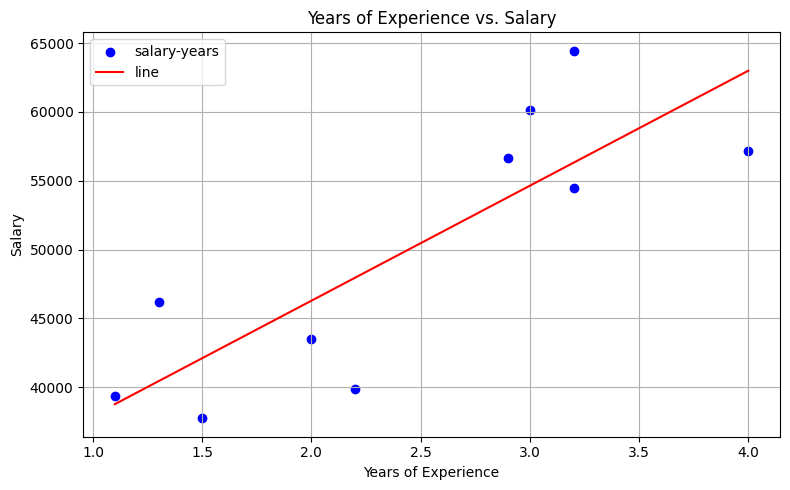

In [13]:
X = df[['years_experience']]
y = df['salary']
model = LinearRegression().fit(X, y)
# 画布设置
plt.figure(figsize=(8, 5))

# 散点图：原始数据点
plt.scatter(X, y, color='blue', label='salary-years')

# 拟合线：线性回归预测
plt.plot(X, model.predict(X), color='red', label='line')

# 标签和图例
plt.title('Years of Experience vs. Salary')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.legend()

# 显示图像
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
df['predicted_salary'] = model.predict(X)
df['residual'] = df['salary'] - df['predicted_salary']

In [15]:
table_name = f"employee_pred_{datetime.now():%Y%m%d_%H%M%S}"

df.to_sql(table_name, con=engine, if_exists="fail", index=False)  # fail=表已存在就报错
print(f"write result in {table_name}")

write result in employee_pred_20250605_152107


In [16]:
df

,id,name,years_experience,salary,predicted_salary,residual
0,1,Alice,1.1,39343.0,38759.110978,583.889022
1,2,Bob,1.3,46205.0,40430.377996,5774.622004
2,3,Charlie,1.5,37731.0,42101.645014,-4370.645014
3,4,David,2.0,43525.0,46279.812560,-2754.812560
4,5,Eve,2.2,39891.0,47951.079578,-8060.079578
5,6,Frank,2.9,56642.0,53800.514142,2841.485858
6,7,Grace,3.0,60150.0,54636.147651,5513.852349
7,8,Heidi,3.2,54445.0,56307.414669,-1862.414669
8,9,Ivan,3.2,64445.0,56307.414669,8137.585331
9,10,Judy,4.0,57189.0,62992.482742,-5803.482742


In [20]:
import pickle, json, io

metrics = {
    "intercept": model.intercept_,
    "coef_years_exp": model.coef_[0],
    "r2": model.score(X, y),
    "trained_at": datetime.utcnow().isoformat()
}

with engine.begin() as conn:
    conn.execute(text("""
        CREATE TABLE IF NOT EXISTS model_registry (
            id INT AUTO_INCREMENT PRIMARY KEY,
            model_name VARCHAR(64),
            metrics JSON,
            model_binary LONGBLOB
        )
    """))
    buf = io.BytesIO()
    pickle.dump(model, buf)

    conn.execute(
        text("INSERT INTO model_registry (model_name, metrics, model_binary) VALUES (:name, :metrics, :binary)"),
        {"name": "salary_linear_v1", "metrics": json.dumps(metrics), "binary": buf.getvalue()}
    )

In [21]:
query = "SELECT id, model_name, metrics FROM model_registry"
df = pd.read_sql(query, con=engine)

In [22]:
df

,id,model_name,metrics
0,1,salary_linear_v1,"{""r2"": 0.6855991685638438, ""intercept"": 29567...."
